In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BertForMaskedLM, AutoModelForMaskedLM, AutoModel

from tqdm.auto import tqdm
tqdm.pandas()

RANDOM_STATE = 1

#set_seed(RANDOM_STATE)
#enable_full_determinism(RANDOM_STATE)


# SentenceTransformers cosine-similarity scoring for (m)class
def st_similarity_scoring(df, model, append=False, name="cos-sim"):
    scores = df.progress_apply(lambda r: simi.pairwise_cosine_similarity(simi.model_embeddings(model, [r["text_a"], r["text_b"]]))[0][0], axis=1)
    scores = pd.Series(scores, index=df.index, name=name)
    if append:
        return df.merge(scores.to_frame(), left_index=True, right_index=True)
    return scores

2024-01-07 11:47:42.661098: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and select test data

In [2]:
df = pd.read_csv("class-arxiv-dataset.csv", index_col=0)
df.sample(5)

,label,categories_a,text_a,categories_b,text_b
8223,0,"('math.AP',)",Estimates of Dirichlet eigenvalues of divergen...,"('math.CO',)",Independent Sets in Direct Products of Vertex-...
11232,0,"('math.AT',)",Biequivariant Maps on Spheres and Topological ...,"('math.CO',)",Betweenness Centrality of Cartesian Product of...
10601,1,"('math.AT',)","Theoretical Geometry, Critical Theory, and Con...","('math.AT',)",Discrete Morse theory for computing cellular s...
29218,1,"('math.GR',)",Loops with abelian inner mapping groups: An ap...,"('math.GR',)",Free subgroups of special linear groups. We pr...
22772,0,"('math.DG',)",Extensions of Lie Brackets. We provide a frame...,"('math.NA',)",New representations of Pad\'e and Pad\'e-type ...


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 43572 eval: 5447 test: 5447


## Model definitions

In [4]:
# Prerequisites for the models
bert_base = models.Transformer('bert-base-uncased')
mathbert_base = models.Transformer('witiko/mathberta')
#bert_finetune_base = models.Transformer("./bert+fine-tune_classi_class_zbmath", tokenizer_name_or_path="bert-base-uncased")
bert_mlm_base = models.Transformer("./bert+re-train_mlm_abstracts_arxiv")
specter2_base = models.Transformer('allenai/specter2_base')

# Definition of models that are evaluated
# combine models into dict
eval_models = {
    "Bert+CLS": SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Bert+MP": SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension())]),
    
    "SBert-MpNet": SentenceTransformer('all-mpnet-base-v2'),
    "SBert-DistilRoberta": SentenceTransformer('all-distilroberta-v1'),
    "SBert-MiniLM-L12": SentenceTransformer('all-MiniLM-L12-v2'),
    "SBert-MiniLM-L6": SentenceTransformer('all-MiniLM-L6-v2'),
    
    "Mathbert+CLS": SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Mathbert+MP": SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension())]),
    
    "Specter 2+CLS": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Specter 2+MP": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension())]),
    
    "SGPT": SentenceTransformer('Muennighoff/SGPT-125M-weightedmean-nli-bitfit'),
    
    "Bert+MLM+CLS": SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension(), pooling_mode="cls")]),
    "Bert+MLM+MP": SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension())]),

    "Bert+TSDAE+CLS": SentenceTransformer('./bert+cls+re-train_tsdae_abstracts_arxiv'),
    "Bert+TSDAE+MP": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv'),
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at witiko/mathberta were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bi

## Spearman-Pearson-rank-coefficient for test data

In [5]:
eval_examples = X_test.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["text_a"], r["text_b"]], label=r["label"]), axis=1)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples, batch_size=64, show_progress_bar=True)

In [6]:
%%time
spear_rancs = {}

with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        spear_rancs[n] = [m.evaluate(evaluator)]
        pb.update()
        
spear_ranc_df = pd.DataFrame(spear_rancs)

  0%|          | 0/15 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

CPU times: user 42min 21s, sys: 1min 5s, total: 43min 27s
Wall time: 21min 33s


In [7]:
pd.set_option('display.max_columns', 40)

In [8]:
spear_ranc_df

,Bert+CLS,Bert+MP,SBert-MpNet,SBert-DistilRoberta,SBert-MiniLM-L12,SBert-MiniLM-L6,Mathbert+CLS,Mathbert+MP,Specter 2+CLS,Specter 2+MP,SGPT,Bert+MLM+CLS,Bert+MLM+MP,Bert+TSDAE+CLS,Bert+TSDAE+MP
0,0.213876,0.290457,0.643324,0.594235,0.606398,0.595313,0.418397,0.363998,0.603502,0.499313,0.295192,0.634073,0.45099,0.457327,0.430931


In [9]:
X_test_score = X_test.copy()

In [10]:
%%time
with tqdm(total=len(eval_models)) as pb:
    for n,m in eval_models.items():
        pb.set_postfix_str("Current model: {}".format(n))
        X_test_score["cos-sim ({})".format(n)] = st_similarity_scoring(X_test, m)
        pb.update()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

  0%|          | 0/5447 [00:00<?, ?it/s]

CPU times: user 1h 14min 22s, sys: 38.8 s, total: 1h 15min 1s
Wall time: 29min 10s


## Results for test data

In [11]:
X_test_score[X_test_score["label"] == 1].describe()

,label,cos-sim (Bert+CLS),cos-sim (Bert+MP),cos-sim (SBert-MpNet),cos-sim (SBert-DistilRoberta),cos-sim (SBert-MiniLM-L12),cos-sim (SBert-MiniLM-L6),cos-sim (Mathbert+CLS),cos-sim (Mathbert+MP),cos-sim (Specter 2+CLS),cos-sim (Specter 2+MP),cos-sim (SGPT),cos-sim (Bert+MLM+CLS),cos-sim (Bert+MLM+MP),cos-sim (Bert+TSDAE+CLS),cos-sim (Bert+TSDAE+MP)
count,2766.0,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000,2766.000000
mean,1.0,0.838782,0.873446,0.332591,0.295185,0.263732,0.305299,0.994973,0.985967,0.867840,0.837160,0.465875,0.680138,0.874323,0.658846,0.376990
std,0.0,0.055495,0.055729,0.126425,0.125524,0.118723,0.126131,0.001533,0.005526,0.027363,0.042362,0.108958,0.100498,0.038842,0.074015,0.106943
min,1.0,0.516032,0.569186,-0.060979,-0.081929,-0.104335,-0.144993,0.987732,0.957446,0.770710,0.588934,0.050500,0.262451,0.712353,0.417165,0.053985
25%,1.0,0.811266,0.846448,0.247741,0.207369,0.182365,0.219482,0.994075,0.983018,0.850629,0.813954,0.397174,0.613301,0.851431,0.608984,0.303894
50%,1.0,0.849561,0.887300,0.333807,0.293561,0.265132,0.304250,0.995198,0.987017,0.869187,0.841948,0.469795,0.688412,0.878429,0.663277,0.374165
75%,1.0,0.877500,0.912716,0.421266,0.381328,0.344557,0.389198,0.996114,0.990022,0.887201,0.866067,0.539885,0.754307,0.901721,0.709006,0.445884
max,1.0,0.958077,0.969173,0.747077,0.759365,0.694437,0.748543,0.998467,0.996017,0.956360,0.941475,0.781308,0.931533,0.969175,0.869653,0.748747


In [12]:
X_test_score[X_test_score["label"] == 0].describe()

,label,cos-sim (Bert+CLS),cos-sim (Bert+MP),cos-sim (SBert-MpNet),cos-sim (SBert-DistilRoberta),cos-sim (SBert-MiniLM-L12),cos-sim (SBert-MiniLM-L6),cos-sim (Mathbert+CLS),cos-sim (Mathbert+MP),cos-sim (Specter 2+CLS),cos-sim (Specter 2+MP),cos-sim (SGPT),cos-sim (Bert+MLM+CLS),cos-sim (Bert+MLM+MP),cos-sim (Bert+TSDAE+CLS),cos-sim (Bert+TSDAE+MP)
count,2681.0,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000,2681.000000
mean,0.0,0.815007,0.840659,0.131338,0.121404,0.098103,0.128000,0.993407,0.982804,0.821307,0.788716,0.399732,0.524904,0.836199,0.606345,0.285351
std,0.0,0.061945,0.062625,0.120213,0.116195,0.105965,0.119112,0.001941,0.005970,0.035375,0.047442,0.104651,0.093394,0.040499,0.067723,0.096319
min,0.0,0.523987,0.533860,-0.127962,-0.150778,-0.204859,-0.197177,0.985567,0.954569,0.707826,0.589938,0.042542,0.239859,0.628286,0.404255,-0.003694
25%,0.0,0.780631,0.804545,0.040484,0.035655,0.019870,0.040006,0.992225,0.979435,0.795414,0.759100,0.331331,0.456632,0.812142,0.559568,0.219789
50%,0.0,0.825779,0.852620,0.119725,0.107935,0.089653,0.118402,0.993626,0.983869,0.822000,0.791753,0.402633,0.521096,0.838980,0.605878,0.281574
75%,0.0,0.859675,0.887337,0.208242,0.200956,0.166787,0.208956,0.994811,0.987196,0.845963,0.822150,0.471562,0.587520,0.863673,0.651558,0.344581
max,0.0,0.944264,0.958502,0.655078,0.571297,0.534978,0.533256,0.998128,0.994352,0.924130,0.922056,0.728108,0.850335,0.948026,0.855771,0.648103


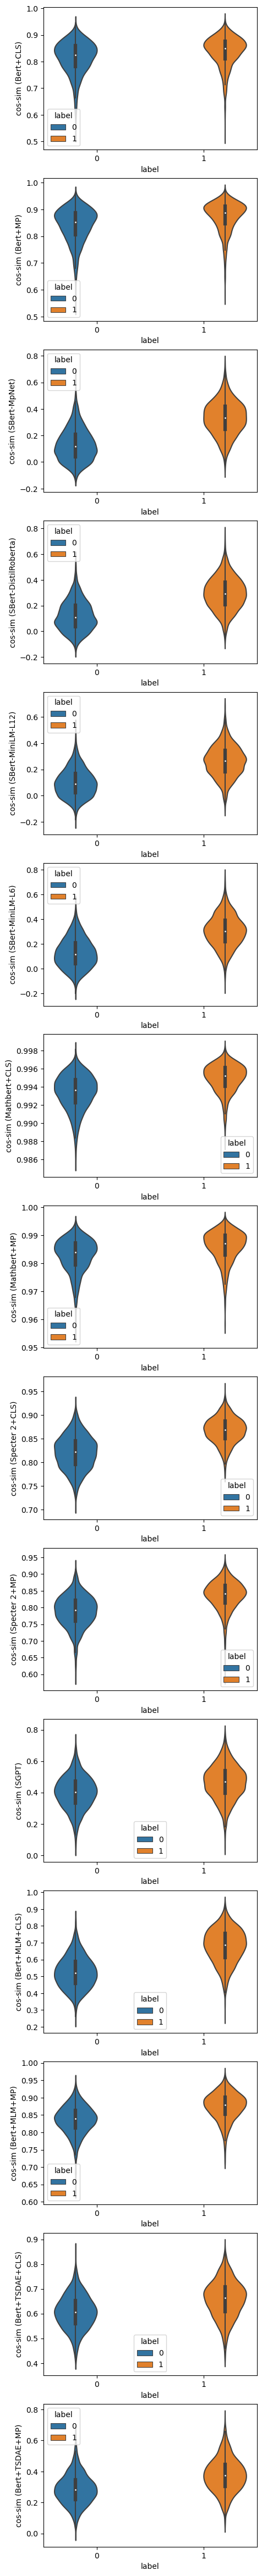

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.violinplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", scale="count", scale_hue=True, ax=axs[i])

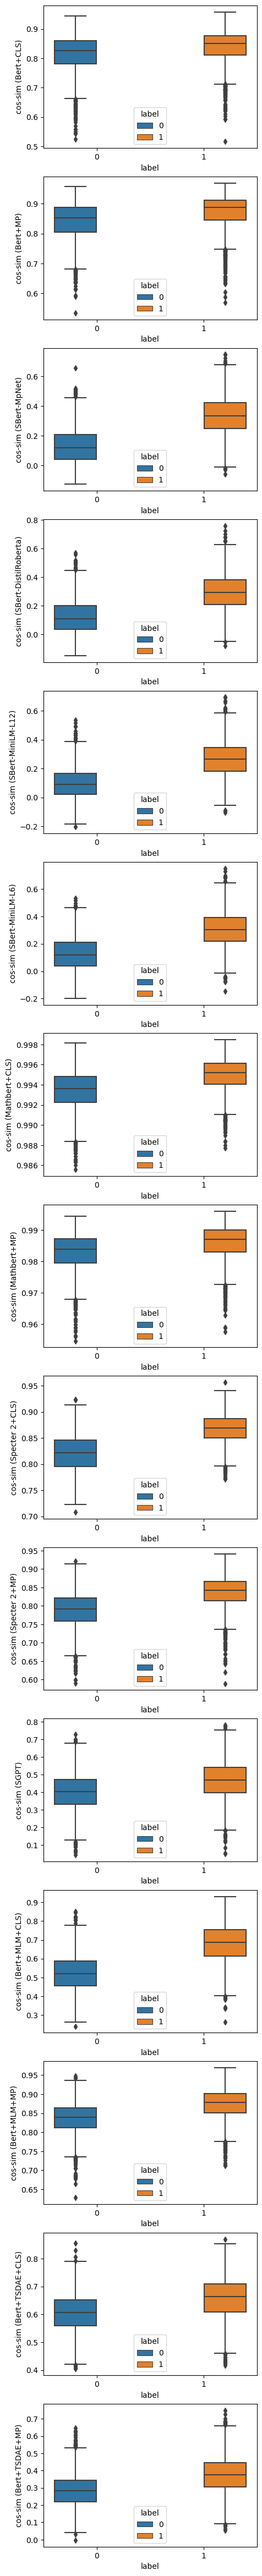

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axs = plt.subplots(len(eval_models), 1, figsize=(5, 4*len(eval_models)))
for i,n in enumerate(eval_models.keys()):
    sns.boxplot(X_test_score, x="label", y="cos-sim ({})".format(n), hue="label", ax=axs[i])

In [15]:
# Die Ergebnisse sehen schon sehr verdächtig aus, müssen wir ggf. Layer freezen? s. https://towardsdatascience.com/what-exactly-happens-when-we-fine-tune-bert-f5dc32885d76
X_test_score.sample(15, random_state=RANDOM_STATE)

,label,categories_a,text_a,categories_b,text_b,cos-sim (Bert+CLS),cos-sim (Bert+MP),cos-sim (SBert-MpNet),cos-sim (SBert-DistilRoberta),cos-sim (SBert-MiniLM-L12),cos-sim (SBert-MiniLM-L6),cos-sim (Mathbert+CLS),cos-sim (Mathbert+MP),cos-sim (Specter 2+CLS),cos-sim (Specter 2+MP),cos-sim (SGPT),cos-sim (Bert+MLM+CLS),cos-sim (Bert+MLM+MP),cos-sim (Bert+TSDAE+CLS),cos-sim (Bert+TSDAE+MP)
14175,1,"('math.CO',)",On Weak Chromatic Polynomials of Mixed Graphs....,"('math.CO',)",Projective Equivalences of k-neighbourly Polyt...,0.867199,0.905863,0.382807,0.412511,0.201615,0.371196,0.996627,0.991128,0.843652,0.833242,0.522773,0.685392,0.891882,0.716439,0.454242
29240,1,"('math.GR',)",Galois Theory - a first course. These notes ar...,"('math.GR',)",On p-stability in groups and fusion systems. T...,0.657862,0.768750,0.393136,0.228238,0.204723,0.249593,0.993512,0.976791,0.873763,0.837479,0.356463,0.548373,0.783294,0.559220,0.355317
31864,1,"('math.KT',)",Controlled $K$-theory and $K$-Homology. An ope...,"('math.KT',)",Cyclic homology of braided Hopf crossed produc...,0.862537,0.812030,0.450993,0.418632,0.363644,0.456449,0.991882,0.987852,0.929821,0.821495,0.626604,0.804001,0.900258,0.740063,0.374875
48373,1,"('math.RA',)",Simple subalgebras of simple special Jordan al...,"('math.RA',)",Normalization of Quaternionic Polynomials. Qua...,0.889704,0.839374,0.332179,0.379683,0.298024,0.357962,0.996923,0.982345,0.868921,0.851242,0.498325,0.731307,0.827755,0.614143,0.418794
11994,1,"('math.CA',)",On some Hadamard-Type Inequalities for Co-ordi...,"('math.CA',)",Non-differentiable solutions for local fractio...,0.823736,0.862196,0.147262,0.069998,0.035535,0.014376,0.995881,0.982802,0.836975,0.822083,0.465442,0.620455,0.806410,0.573876,0.394016
48427,1,"('math.RA',)",Basic superranks for varieties of algebras. We...,"('math.RA',)",A note on solvable maximal subgroups in subnor...,0.816065,0.910045,0.390135,0.397936,0.418222,0.434257,0.994980,0.983692,0.908056,0.888271,0.426440,0.800276,0.914737,0.675249,0.414313
22315,0,"('math.DG',)",Tensor tomography on Cartan-Hadamard manifolds...,"('math.OC',)",A new conical internal evolutive LP algorithm....,0.887058,0.875548,0.131517,0.083227,0.088011,0.058395,0.994388,0.986721,0.841711,0.801138,0.391310,0.498491,0.837436,0.571529,0.172861
51367,1,"('stat.AP',)",Data-driven dynamic treatment planning for chr...,"('stat.AP',)",Statistical analysis of stellar evolution. Col...,0.851257,0.865209,0.207407,0.209408,0.090080,0.171641,0.993348,0.989213,0.834599,0.829591,0.291338,0.517637,0.881408,0.723925,0.423259
39212,0,"('math.NT',)",The distribution of spacings between the fract...,"('math.FA',)",Canonical graph contractions of linear relatio...,0.869443,0.892795,0.094591,0.159251,0.053049,0.144725,0.993560,0.982798,0.832025,0.827467,0.454631,0.563777,0.880406,0.571476,0.247713
51254,1,"('stat.AP',)",Bayesian model averaging for mortality forecas...,"('stat.AP',)",Selection of multiple donor gauges via Graphic...,0.847881,0.941967,0.220037,0.268150,0.306583,0.259077,0.996949,0.994287,0.871363,0.885255,0.497503,0.732055,0.913660,0.783290,0.597541
